# Random Forest Final Model - Gosan, South Korea

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import sys
sys.path.append('../../')
import config

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [2]:
site = config.site
site_name = config.site_dict[site]
assert site == 'GSN', 'This script is only for Gosan, South Korea. The site can be changed in the config file.'

compound = config.compound

print(f"Creating a random forest model for \033[1m{site_name}\033[0;0m.")

Creating a random forest model for Gosan, South Korea.


### Loading & Initialising Data

In [3]:
data = pd.read_csv(data_path/f'for_model_pca_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,flag
1228,2008-11-29 11:00:00,-6.826209,2.310110,3.817421,-4.748856,3.658341,1.728333,-3.668466,-1.653627,-2.862235,...,1.931569,1.717639,-0.881380,0.467869,3.456884,-0.175605,2.110481,-0.615861,1.479803,1.0
9250,2016-03-24 15:00:00,-3.294349,-4.757997,4.078982,0.084855,-0.170853,-2.111675,-1.909664,-0.343229,0.233294,...,-0.464156,-0.235993,-1.941107,1.338982,0.106307,-0.196612,1.332944,2.244745,0.055247,0.0
8956,2016-01-12 13:00:00,-7.096836,2.211436,0.574424,0.810637,0.748342,-1.888225,-1.227911,-1.054601,0.739848,...,1.598392,-0.175277,-0.786719,0.226976,0.083059,-0.359940,1.113494,0.007154,-0.893833,1.0
6765,2013-08-23 05:00:00,10.760377,1.730385,1.124844,2.088764,-5.901646,5.230977,-2.373544,-1.066562,0.206568,...,-0.060224,-2.209361,-2.758401,-2.000057,0.174377,-0.909984,0.433794,-1.767179,0.783617,1.0
1214,2008-11-22 11:00:00,1.300509,-0.397876,-3.335520,3.662355,-0.077700,-0.198850,0.353077,1.331811,-0.405577,...,-0.828162,1.644180,-1.854018,0.111693,0.350274,0.553465,-0.562080,-0.407134,-1.184536,1.0


In [4]:
train_data = data[(data['time'].dt.year >= 2011) & (data['time'].dt.year <= 2013)]
val_data = data[(data['time'].dt.year >= 2014) & (data['time'].dt.year <= 2014)]
test_data = data[(data['time'].dt.year >= 2015) & (data['time'].dt.year <= 2017)]


print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2011-01-01 11:00:00 -> 2013-12-30 09:00:00. Length: 3186
Val range: 2014-01-03 19:00:00 -> 2014-12-31 23:00:00. Length: 933
Test range: 2015-01-01 01:00:00 -> 2017-12-31 23:00:00. Length: 2824


### Model

In [5]:
# fitting models based on optimal hyperparameters

rf_model = RandomForestClassifier(random_state=42,
                                  n_estimators=200,
                                  max_depth=5,
                                  criterion='entropy',
                                  bootstrap=True,
                                  max_features=None,)

rf_model.fit(X_train, y_train)

class_probabilities_val = rf_model.predict_proba(X_val)
class_probabilites_train = rf_model.predict_proba(X_train)

confidence_threshold = config.confidence_threshold

y_pred_val = (class_probabilities_val[:, 1] >= confidence_threshold).astype(int)
y_pred_train = (class_probabilites_train[:, 1] >= confidence_threshold).astype(int)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")

Precision on Training Set = 0.976
Precision on Validation Set = 0.923
Recall on Training Set = 0.814
Recall on Validation Set = 0.596
F1 Score on Training Set = 0.888
F1 Score on Validation Set = 0.724


In [6]:
# evaluating the model on the test set

class_probabilities_test = rf_model.predict_proba(X_test)

y_pred_test = (class_probabilities_test[:, 1] >= confidence_threshold).astype(int)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Test Set = {precision_test:.3f}")
print(f"Recall on Test Set = {recall_test:.3f}")
print(f"F1 Score on Test Set = {f1_test:.3f}")

Precision on Test Set = 0.921
Recall on Test Set = 0.722
F1 Score on Test Set = 0.809


In [7]:
# saving model
dump(rf_model, data_path/f'rf_model_GSN.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\rf_model_GSN.joblib']

### Assessing Feature Importance

C:\Users\kirst\AppData\Local\Temp\ipykernel_25336\1972167015.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(feature_importances.index)


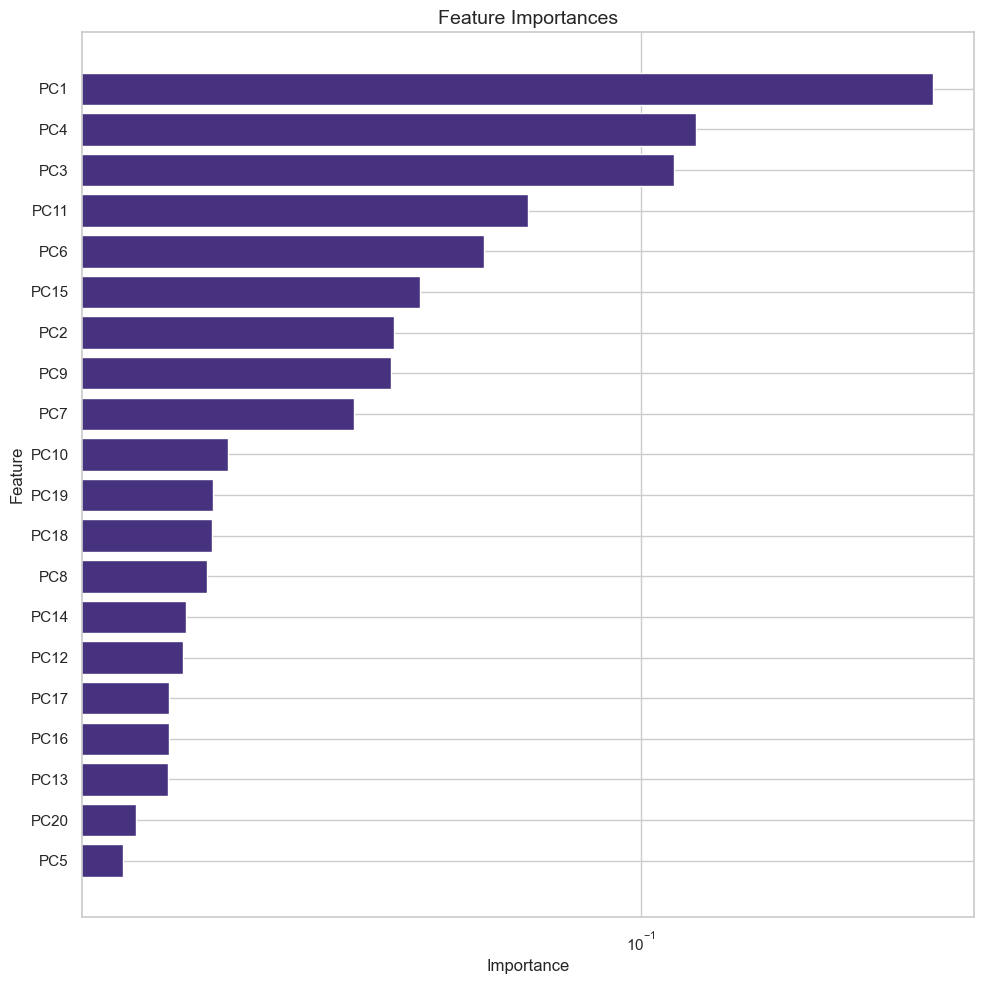

In [16]:
# finding most important features in the model
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 10))
sns.set(style='whitegrid')
sns.set_palette("viridis")

# sorting feature importances
feature_importances = feature_importances.sort_values('importance', ascending=True)

# bar chart of feature importances
ax.barh(feature_importances.index, feature_importances['importance'])

# making y axis logaritmic
ax.set_xscale('log')

ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
ax.set_title('Feature Importances', fontsize=14)
ax.set_yticklabels(feature_importances.index)

fig.tight_layout()

In [12]:
# retrieving loadings from model setup
loadings = pd.read_csv(data_path/f'pca_loadings_{compound}_{site}.csv', index_col=0)
loadings

# extracting loadings of three most important PCAs
pca1 = loadings.iloc[:, 0]
pca4 = loadings.iloc[:, 1]
pca3 = loadings.iloc[:, 10]

# identifying features with the highest loadings in top 3 PCAs
pca1_features = pca1.abs().sort_values(ascending=False)
pca4_features = pca4.abs().sort_values(ascending=False)
pca3_features = pca3.abs().sort_values(ascending=False)

print(f"Top 5 features in PCA1: {pca1_features.head(3).index.values}")
print(f"Top 5 features in PCA4: {pca4_features.head(3).index.values}")
print(f"Top 5 features in PCA3: {pca3_features.head(3).index.values}")

Top 5 features in PCA1: ['u500_4' 'u500_3' 'u500_3_past']
Top 5 features in PCA4: ['u850_0' 'u850_7_past' 'u850_7']
Top 5 features in PCA3: ['u10_4' 'v850_8_past' 'u850_4']


In [13]:
# identifying what position importance blh
print(f"Position of 'blh' in PCA1: {pca1_features.index.get_loc('blh')}")
print(f"Position of 'blh' in PCA4: {pca4_features.index.get_loc('blh')}")
print(f"Position of 'blh' in PCA3: {pca3_features.index.get_loc('blh')}")

Position of 'blh' in PCA1: 38
Position of 'blh' in PCA4: 126
Position of 'blh' in PCA3: 116


Text(0.5, 1.02, 'Feature Importances for PCA Loadings')

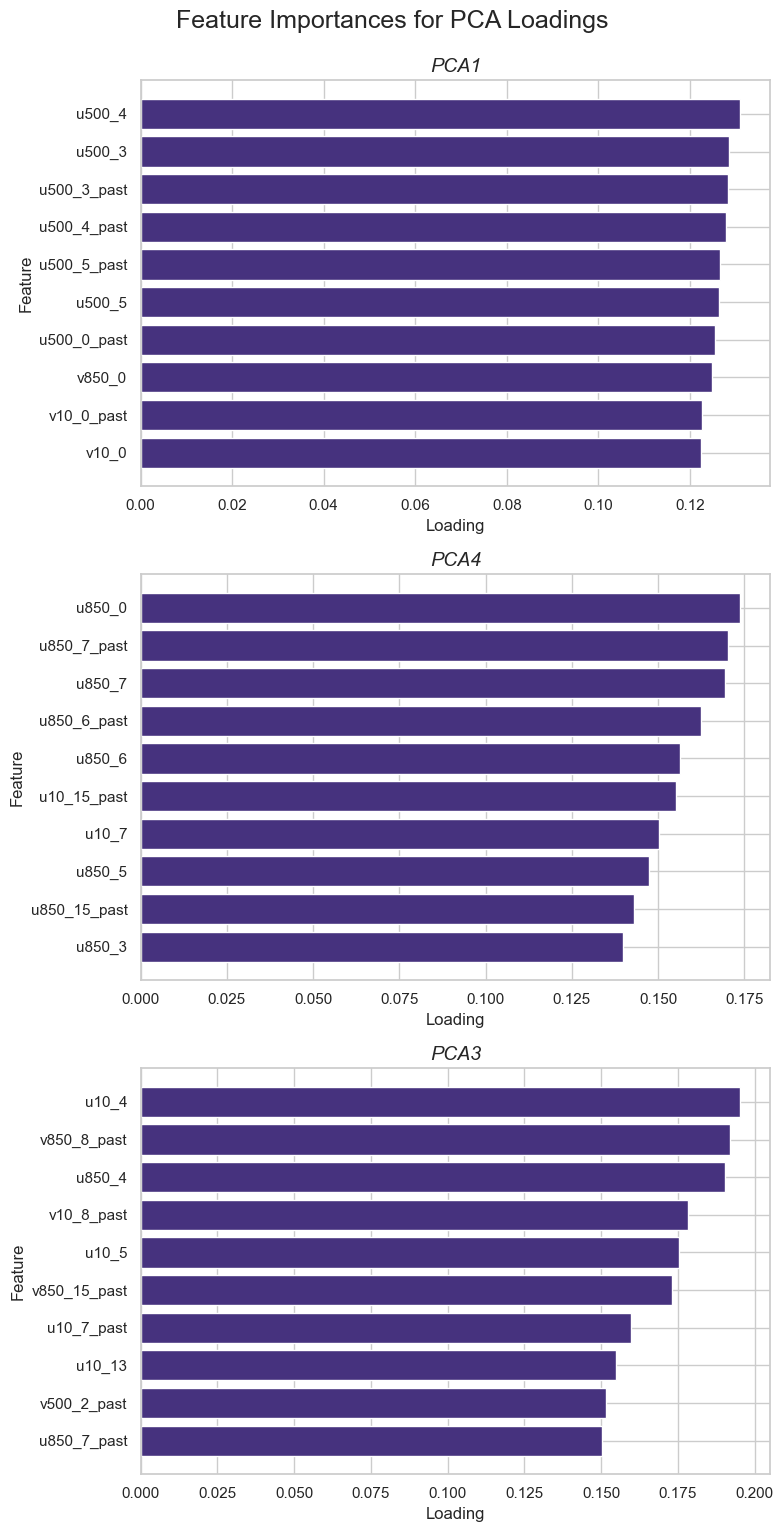

In [15]:
# plotting feature importances for loading of top 3 PCAs
fig, axes = plt.subplots(3,1,figsize=(8, 15))
sns.set(style='whitegrid')
sns.set_palette("viridis")

# filtering feature importances for PCA2 - only including 10 most important features and sorting them
pca1_features = pca1_features.loc[pca1_features.index[:10]].sort_values(ascending=True)
pca4_features = pca4_features.loc[pca4_features.index[:10]].sort_values(ascending=True)
pca3_features = pca3_features.loc[pca3_features.index[:10]].sort_values(ascending=True)

# bar chart of feature importances
axes[0].barh(pca1_features.index, pca1_features)
axes[1].barh(pca4_features.index, pca4_features)
axes[2].barh(pca3_features.index, pca3_features)

# adding titles and labels
axes[0].set_ylabel('Feature')
axes[0].set_xlabel('Loading')
axes[0].set_title('PCA1', fontsize=14, fontstyle='italic')

axes[1].set_ylabel('Feature')
axes[1].set_xlabel('Loading')
axes[1].set_title('PCA4', fontsize=14, fontstyle='italic')

axes[2].set_ylabel('Feature')
axes[2].set_xlabel('Loading')
axes[2].set_title('PCA3', fontsize=14, fontstyle='italic')

fig.tight_layout()
fig.suptitle('Feature Importances for PCA Loadings', fontsize=18, y=1.02)